In [1]:
from IRDataAnal import *
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 1.4
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.bottom'] = True
plt.rcParams["axes.labelweight"] = "bold"

mpl.rcParams['figure.dpi'] = 400

mpl.rcParams['font.size'] = 8
mpl.rcParams["font.weight"] = "bold"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import copy 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from sklearn.neighbors import KernelDensity

import itertools
from sklearn.metrics import mean_absolute_error

In [5]:
import pymc as pm
import arviz as az
from pymc import HalfCauchy, Model, Normal, sample, HalfNormal, model_to_graphviz
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
import sklearn

In [7]:
from colour import Color

In [68]:
ir = calibrationData('../hplc and IR data/IR data/', '../hplc and IR data/HPLC data for training/', ['prod'])

Loading IR data......
ac0089-1
ac0089-2
ac0089-3
ac0091-1
ac0091-2
ac0091-4
ac0091-5
Loading LC data......
ac0089-1.xlsx
ac0089-2.xlsx
ac0089-3.xlsx
ac0091-1.xlsx
ac0091-2.xlsx
ac0091-4.xlsx
ac0091-5.xlsx


In [69]:
subtract_list = [14,13,10,8,10,11,13]
clist = ['b', 'orange', 'g', 'r', 'm', 'brown', 'cyan']

## Variation use MAE

In [70]:
ind1, ind2 = 445, 475
IR_signal = [heightTwoPoints, peakAreaTwoPoints]
derivatives = [[1, 1156], [2, 1165]]
baselinepoints = [True, False]  # true means using isosbestic point
smooth_param = [None, [5, 2]]
test_index_all = [0, 1, 2, 3, 4, 5, 6]
overall_score = []

for i in range(7): 
    train_index = i
    test_index = copy.deepcopy(test_index_all)
    _ = test_index.pop(i)
    print(test_index)
    overall_wavenumber_range = [[ind1], [ind2]]
    temp_score = []
    
    irs_, der_, bp_, sp_ = [], [], [], []
    
    counter = 0
    
    for irs in IR_signal: 
        for der in derivatives: 
            for bp in baselinepoints: 
                for sp in smooth_param: 
                    print((counter, irs, der, bp, sp))
    
                    ir.preprocess(overall_wavenumber_range[0], overall_wavenumber_range[1], isTruncateData=False,
                                  isSubtractAny=subtract_list, isSNV=False, isDerivative=der[0],
                                  truncateWaveNUmber=None, skip=False, isSmooth=sp)
                    
                    ir_trend_list_match_lc = generateTrends(irs, ir.raw_ir_data_preprocess, 
                                                            ir.new_dataLList, ir.wave_number_preprocess[::-1], der[1], diagnostic=False,
                                                            isosbestic=bp)
                    all_cal_data = prepDataUnivariateCal(ir_trend_list_match_lc, ir.new_dataLList, ir.lc_data)
    
                    startpoint, endpoint = 2, 18
                    x = np.array(all_cal_data[train_index][1][startpoint:endpoint]).reshape(-1, 1)
                    y = np.array(all_cal_data[train_index][0][startpoint:endpoint])
                    rgr = LinearRegression(fit_intercept=False)
                    rgr.fit(x, y)
                    preds = []
                    obs = []
    
                    for ti in test_index: 
                        preds.append(rgr.predict(np.array(all_cal_data[ti][1][startpoint:endpoint]).reshape(-1, 1)))
                        obs.append(np.array(all_cal_data[ti][0][startpoint:endpoint]))
    
                    preds = np.array(preds).flatten()
                    obs = np.array(obs).flatten()
    
                    temp_score.append(mean_absolute_error(obs, preds))
                    
                    counter += 1

    overall_score.append(np.array(temp_score))

[1, 2, 3, 4, 5, 6]
(0, <function heightTwoPoints at 0x000002B49F070860>, [1, 1156], True, None)
(1, <function heightTwoPoints at 0x000002B49F070860>, [1, 1156], True, [5, 2])
(2, <function heightTwoPoints at 0x000002B49F070860>, [1, 1156], False, None)
(3, <function heightTwoPoints at 0x000002B49F070860>, [1, 1156], False, [5, 2])
(4, <function heightTwoPoints at 0x000002B49F070860>, [2, 1165], True, None)
(5, <function heightTwoPoints at 0x000002B49F070860>, [2, 1165], True, [5, 2])
(6, <function heightTwoPoints at 0x000002B49F070860>, [2, 1165], False, None)
(7, <function heightTwoPoints at 0x000002B49F070860>, [2, 1165], False, [5, 2])
(8, <function peakAreaTwoPoints at 0x000002B49F070900>, [1, 1156], True, None)
(9, <function peakAreaTwoPoints at 0x000002B49F070900>, [1, 1156], True, [5, 2])
(10, <function peakAreaTwoPoints at 0x000002B49F070900>, [1, 1156], False, None)
(11, <function peakAreaTwoPoints at 0x000002B49F070900>, [1, 1156], False, [5, 2])
(12, <function peakAreaTwoPoi

In [58]:
def averageEffects(score_list, effect_index):
    
    n_res = len(score_list)
    ypos, yneg = [], []
    inc = int(n_res / (2**(effect_index)))
    pos_start, pos_end, neg_start, neg_end = 0, inc, inc, inc*2
    neg_end_i = inc*2
    for i in range(2**(effect_index-1)): 
        
        ypos.append(score_list[pos_start:pos_end])
        yneg.append(score_list[neg_start:neg_end])
        
        pos_start += neg_end_i
        pos_end += neg_end_i
        neg_start += neg_end_i
        neg_end += neg_end_i

    print('---')

    return np.array(ypos), np.array(yneg)

In [65]:
overall_effects = []
for i in range(7): 
    temp_effects = []
    for j in range(4): 
        ypos, yneg = averageEffects(overall_score[i, :], j+1)
        effects = np.log(ypos.mean()) - np.log(yneg.mean())
        temp_effects.append(effects)
    overall_effects.append(temp_effects)

0 8 8 16
---
0 4 4 8
8 12 12 16
---
0 2 2 4
4 6 6 8
8 10 10 12
12 14 14 16
---
0 1 1 2
2 3 3 4
4 5 5 6
6 7 7 8
8 9 9 10
10 11 11 12
12 13 13 14
14 15 15 16
---
0 8 8 16
---
0 4 4 8
8 12 12 16
---
0 2 2 4
4 6 6 8
8 10 10 12
12 14 14 16
---
0 1 1 2
2 3 3 4
4 5 5 6
6 7 7 8
8 9 9 10
10 11 11 12
12 13 13 14
14 15 15 16
---
0 8 8 16
---
0 4 4 8
8 12 12 16
---
0 2 2 4
4 6 6 8
8 10 10 12
12 14 14 16
---
0 1 1 2
2 3 3 4
4 5 5 6
6 7 7 8
8 9 9 10
10 11 11 12
12 13 13 14
14 15 15 16
---
0 8 8 16
---
0 4 4 8
8 12 12 16
---
0 2 2 4
4 6 6 8
8 10 10 12
12 14 14 16
---
0 1 1 2
2 3 3 4
4 5 5 6
6 7 7 8
8 9 9 10
10 11 11 12
12 13 13 14
14 15 15 16
---
0 8 8 16
---
0 4 4 8
8 12 12 16
---
0 2 2 4
4 6 6 8
8 10 10 12
12 14 14 16
---
0 1 1 2
2 3 3 4
4 5 5 6
6 7 7 8
8 9 9 10
10 11 11 12
12 13 13 14
14 15 15 16
---
0 8 8 16
---
0 4 4 8
8 12 12 16
---
0 2 2 4
4 6 6 8
8 10 10 12
12 14 14 16
---
0 1 1 2
2 3 3 4
4 5 5 6
6 7 7 8
8 9 9 10
10 11 11 12
12 13 13 14
14 15 15 16
---
0 8 8 16
---
0 4 4 8
8 12 12 16
---
0 2 

In [66]:
overall_effects = np.array(overall_effects)

In [61]:
overall_effects

array([[-1.29309204,  0.260304  ,  1.52351132,  0.02114592],
       [-1.48396844,  0.36729045,  1.63603692,  0.04513229],
       [-1.868269  ,  0.59262587,  1.46258306,  0.10336273],
       [-1.80029893,  0.73500881,  1.90270415,  0.50344232],
       [-1.90847718,  0.74062391,  2.00669996,  0.12916831],
       [-1.30584819,  0.36237744,  1.51462798, -0.02298822],
       [-1.63059221,  0.32947435,  1.42283233,  0.10806966]])

(-1.0, 1.0)

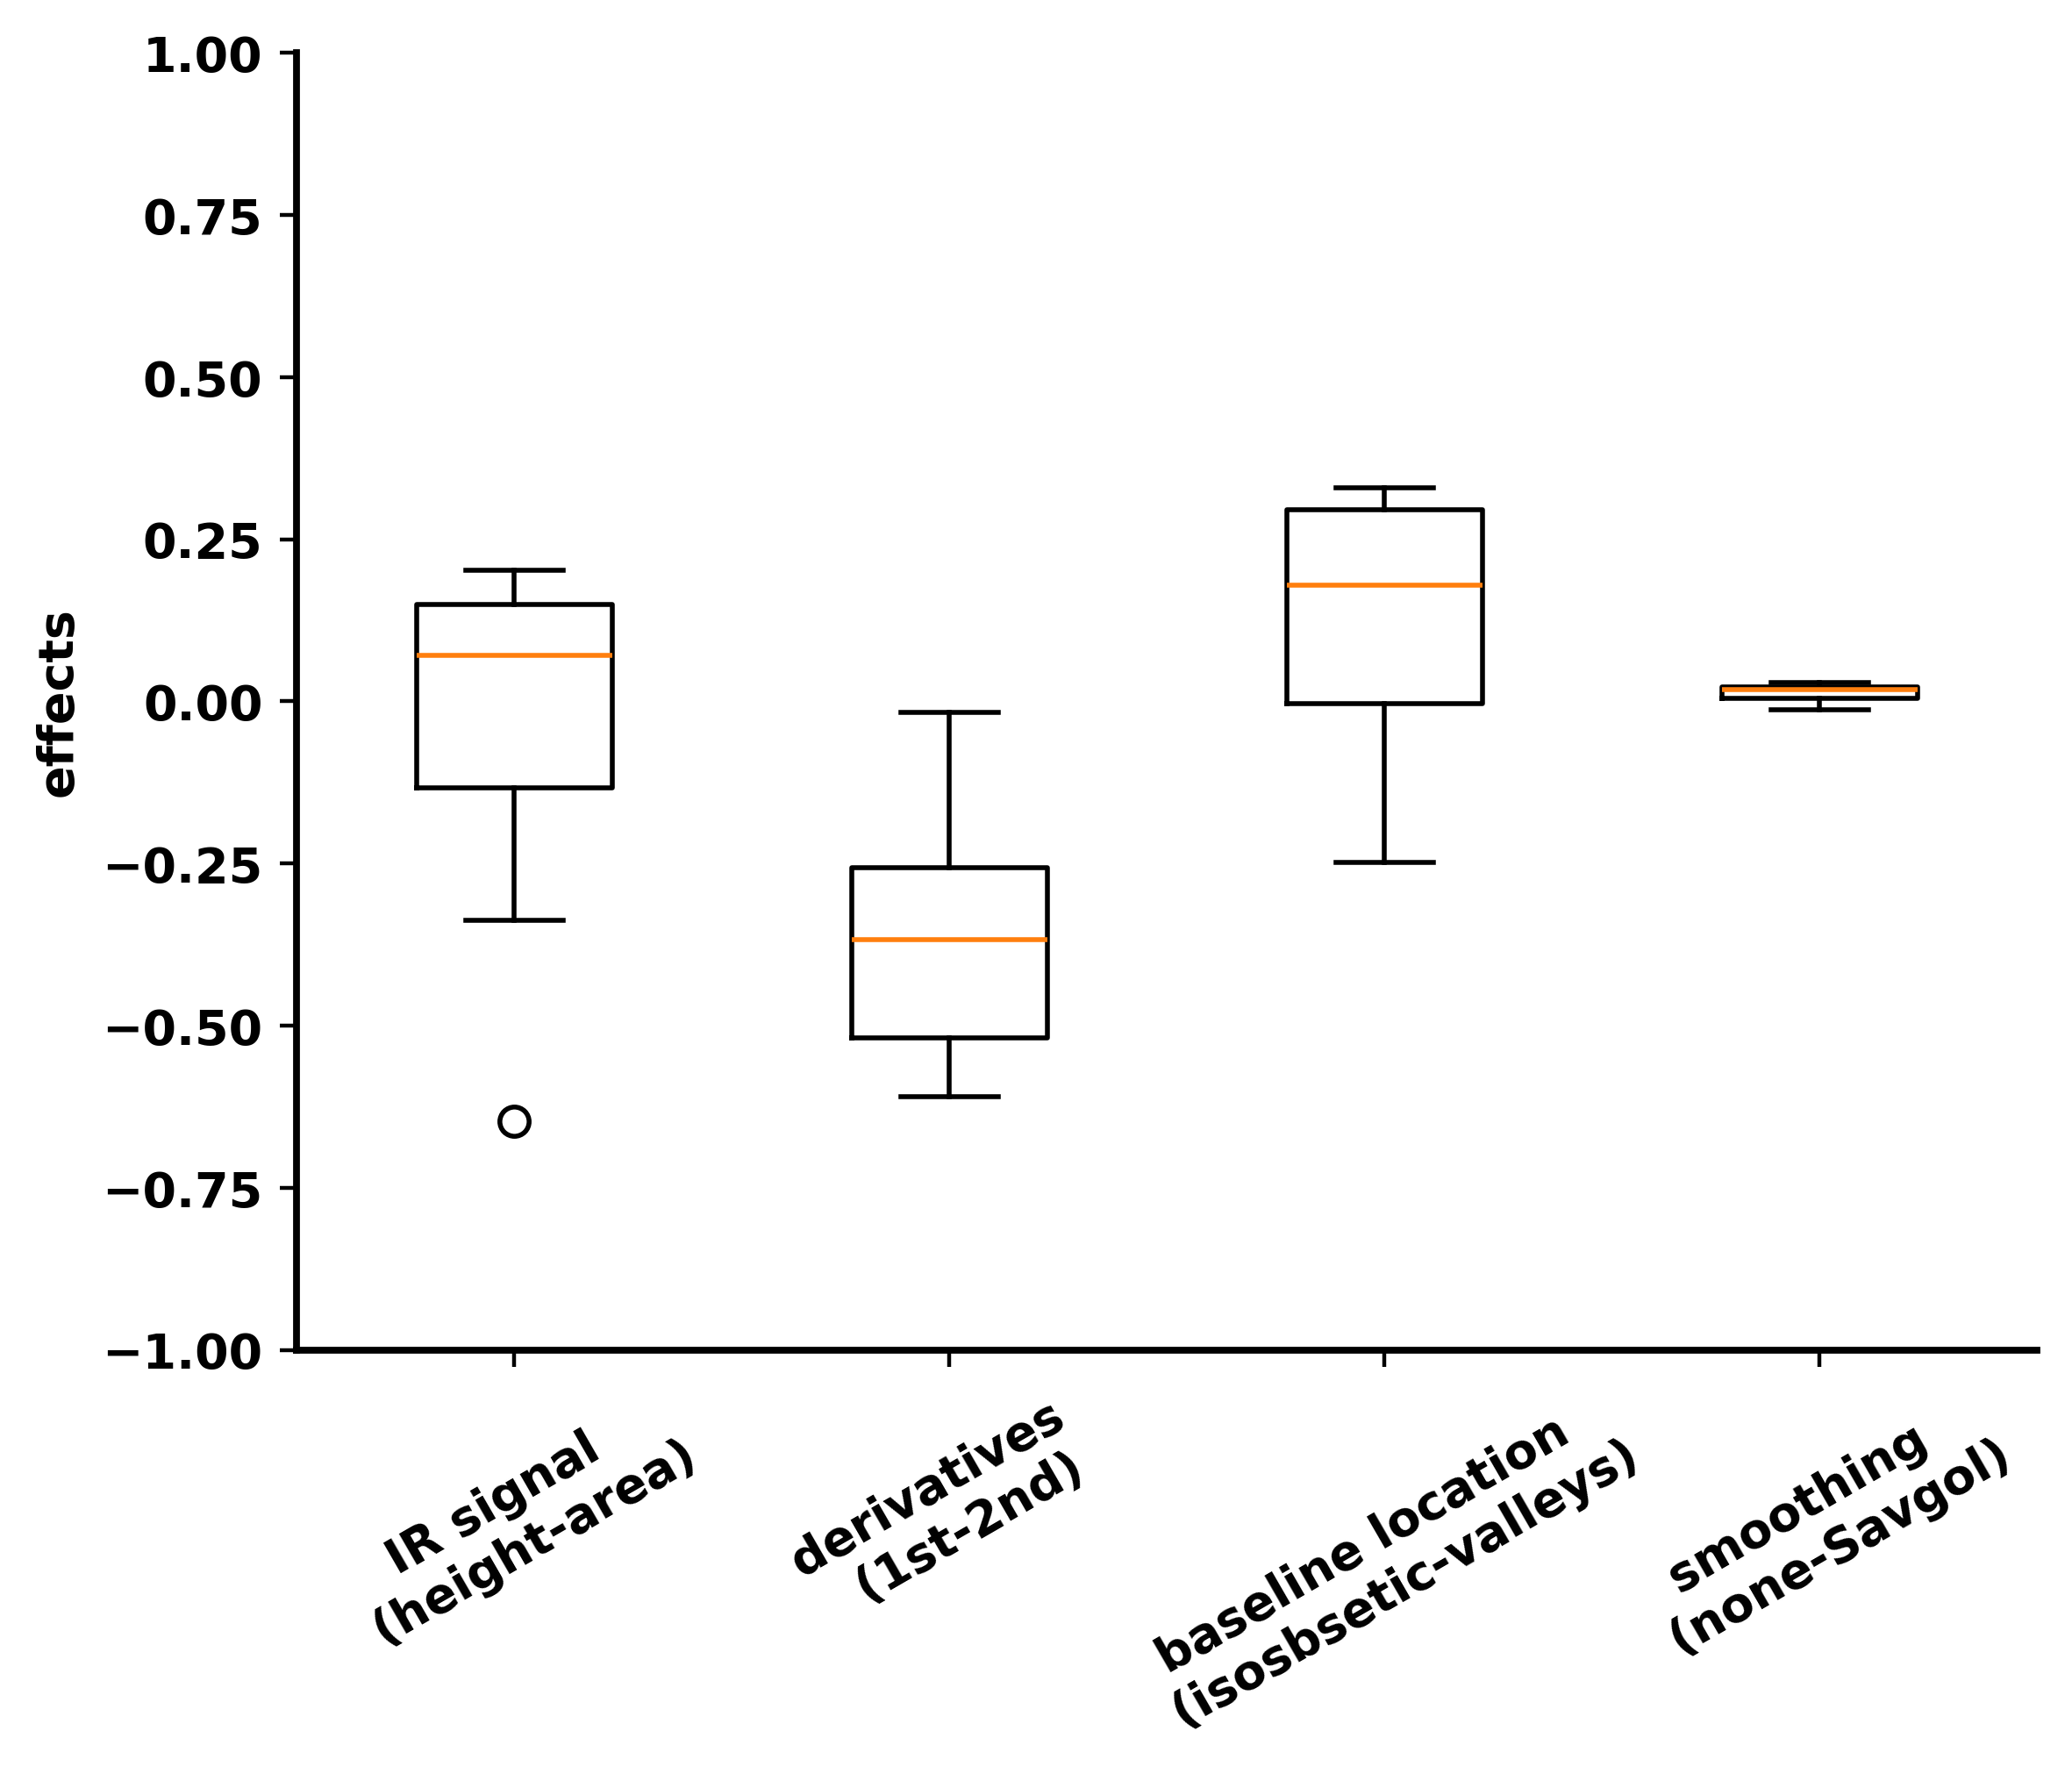

In [77]:
mpl.rcParams['font.size'] = 10

labels = ['IR signal \n (height-area)', 'derivatives \n (1st-2nd)', 'baseline location \n (isosbsetic-valleys)', 'smoothing \n (none-Savgol)']
plt.boxplot(overall_effects_updated)
plt.xticks(ticks=[1, 2, 3, 4], labels=labels, rotation=30);
plt.ylabel('effects');
plt.ylim(-1, 1)

In [13]:
def getIRTrends(ir, method_): 

    s, e = 0, ir.new_dataLList[0]
    trend_list = []
    
    for i in range(len(ir.new_dataLList)): 
    
        temp_abs = ir.raw_ir_data_preprocess[s:e, :]
        temp_trend = []
        
        for j in range(temp_abs.shape[0]):
            spec = np.hstack((ir.wave_number_preprocess[:, np.newaxis], temp_abs[j, :][:, np.newaxis]))
            # temp_trend.append(heightToZero(spec))
            temp_trend.append(method_(0, -1, spec))
    
        trend_list.append(temp_trend)
    
        s = e
        if i == len(ir.new_dataLList) - 1: 
            e = -1
        else: 
            e = e + ir.new_dataLList[i+1]
            
    return trend_list

In [14]:
def reformatIRdata(ir, trend_list): 

    s, e = 0, ir.new_dataLList[0]
    
    all_cal_data = []
    
    for i in range(len(ir.new_dataLList)): 
    
        all_cal_data.append([ir.lc_data[s:e, :], trend_list[i]])
    
        s = e
        if i == len(ir.new_dataLList) - 1: 
            e = -1
        else: 
            e = e + ir.new_dataLList[i+1]

    x_all, y_all = [], []
    for i in range(len(all_cal_data)): 
    
        x_all.append(all_cal_data[i][1])
        y_all.append(all_cal_data[i][0])
    
    x_all, y_all = np.concatenate(x_all), np.concatenate(y_all)

    return all_cal_data, x_all, y_all 